# Potato Nematode Predictor
This work contains the public sector consultancy work on a potato nematode predictor carried out by Aarhus University.

Start by configuring the notebook:

In [1]:
import wget
import geopandas
import os
import rasterio
import sys
import fiona
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from pathlib import Path
from zipfile import ZipFile
from tqdm.autonotebook import tqdm

from utils import RasterstatsMultiProc

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Define which field polygons should be used for analysis (2017 to 2019 seem to follow the same metadata format)
FIELD_POLYGONS = ['FieldPolygons2017', 'FieldPolygons2018', 'FieldPolygons2019']

# Define global flags
CROP_TYPES = ['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 'Vinterbyg', 'Permanent græs, normalt udbytte']  
ONLY_POTATO = False
MULTI_PROC_ZONAL_STATS = True
ALL_TOUCHED = False
BUFFER_SIZE = -20  # Unit is meter

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from ipykernel import kernelapp as app


---
Download the field polygons from The Danish Agricultural Agency:

In [2]:
# Downloaded files will go into the 'data/external' folder
dest_folder = PROJ_PATH / 'data' / 'external'
if not dest_folder.exists():
    os.makedirs(dest_folder)
    
# Define the download links for the field polygons for the individual years
file_url_mapping = {
    'FieldPolygons2016.zip': 'https://kortdata.fvm.dk/download/DownloadStream?id=3037da0f2744a85adc8b08ca5c31c3cb',
    'FieldPolygons2017.zip': 'https://kortdata.fvm.dk/download/DownloadStream?id=d0c8946763e465bf9f6160a6bc40531f',
    'FieldPolygons2018.zip': 'https://kortdata.fvm.dk/download/DownloadStream?id=cfb1b47130b7276f8515fbaae60bde2a',
    'FieldPolygons2019.zip': 'https://kortdata.fvm.dk/download/DownloadStream?id=3d19613ac986ed05a7c301319738e332'
}

# Download the zipfiles
for filename, url in file_url_mapping.items():
    dest_path = PROJ_PATH / 'data' / 'external' / filename
    if not dest_path.exists():
        wget.download(url, str(dest_path))
        print("File has been downloaded: " + filename)
    else:
        print("File already exists: " + str(PROJ_PATH / 'data' / 'external' / filename))

File already exists: /home/jovyan/work/data/external/FieldPolygons2016.zip
File already exists: /home/jovyan/work/data/external/FieldPolygons2017.zip
File already exists: /home/jovyan/work/data/external/FieldPolygons2018.zip
File already exists: /home/jovyan/work/data/external/FieldPolygons2019.zip
time: 16.9 ms


---
Then extract the zipfiles:

In [3]:
# The extracted zipfiles will go into the 'data/raw' folder
for zipfile in (PROJ_PATH / 'data' / 'external').glob('**/*.zip'):
    dest_folder = PROJ_PATH / 'data' / 'raw' / zipfile.stem   
    if not dest_folder.exists():
        with ZipFile(str(zipfile), 'r') as zipObj:
            zipObj.extractall(str(dest_folder))
        print("Zipfile has been extracted: " + str(zipfile))
    else:
        print("Zipfile has already been extracted: " + str(zipfile))

Zipfile has already been extracted: /home/jovyan/work/data/external/FieldPolygons2019.zip
Zipfile has already been extracted: /home/jovyan/work/data/external/FieldPolygons2016.zip
Zipfile has already been extracted: /home/jovyan/work/data/external/FieldPolygons2017.zip
Zipfile has already been extracted: /home/jovyan/work/data/external/FieldPolygons2018.zip
time: 17.9 ms


---
Now the most common crop types for the individual years

In [4]:
if False:  # Set it to True if you want to find the results
    for df_name in FIELD_POLYGONS:
        shp_path = list((PROJ_PATH / 'data' / 'raw' / df_name).glob('**/*.shp'))[0]
        df = geopandas.read_file(str(shp_path))   
        
        # Change all column names to be lower-case to make the naming consistent across years (https://stackoverflow.com/a/36362607/12045808)
        df.columns = map(str.lower, df.columns)

        # Find most common crop types
        n = 15 
        crop_types = df['afgroede'].value_counts()[:n].index.tolist()
        print("### Analyzing " + df_name + " ###")
        for crop_type in crop_types:
            num_fields = df[df['afgroede'] == crop_type].shape[0]
            afgkode = df[df['afgroede'] == crop_type].iloc[0]['afgkode']
            print("Crop type: {} (fields={}, afgkode={})".format(crop_type, num_fields, int(afgkode)))
        print("")

time: 30.1 ms


---
Find the potato fields and count the number of unique sorts:

In [5]:
def buffer_and_analyze_fields(shp_path, only_potato=True, crop_types=['Vinterhvede']):
    # Load shapefile into dataframe and remove NaN rows
    df = geopandas.read_file(str(shp_path))
    df = df.dropna()
    
    # Change all column names to be lower-case to make the naming consistent across years (https://stackoverflow.com/a/36362607/12045808)
    df.columns = map(str.lower, df.columns)
    
    # Extract crop types 
    df_extracted = df[df['afgroede'].str.contains('kartof', case=False)]
    if not only_potato:
        for crop_type in crop_types:  
            df_crop = df[df['afgroede'] == crop_type]
            df_crop = df_crop.sample(n=5000)  # Get a maximum of n fields for each crop type
            df_extracted = df_extracted.append(df_crop)
    df = df_extracted
    
    # Buffer the geometries to take imprecise coregistration into consideration (important for zonal statistics)
    df['geometry'] = df['geometry'].values.buffer(BUFFER_SIZE)
    df = df[~df['geometry'].is_empty]  # Filter away all empty polygons (ie. fields with zero area after buffering)
    
    # Find the total number of fields
    num_fields = df.shape[0]
    sum_area = df['imk_areal'].sum()
    print("### Analyzing " + df_name + " (after buffering of " + str(BUFFER_SIZE) + "m) ###")
    print("There are a total of " + str(num_fields) + " fields (total area = " + str(int(sum_area)) + " ha)")

    # Find the different crop types, count the number of fields for each type, and calculate total area for each type
    extracted_crop_types = df['afgroede'].unique()
    for crop_type in sorted(extracted_crop_types):
        num_fields = df[df['afgroede'] == crop_type].shape[0]
        sum_area = df[df['afgroede'] == crop_type]['imk_areal'].sum()
        print("There are " + str(num_fields) + " fields (total area = " + str(int(sum_area)) + " ha) of type: " + crop_type)

    print("")
    
    return df 

time: 28 ms


In [6]:
# Buffer and analyze the field polygons
for df_name in FIELD_POLYGONS:
    shp_src_path = list((PROJ_PATH / 'data' / 'raw' / df_name).glob('**/*.shp'))[0]
    shp_dest_name = '{}_buffered'.format(df_name)
    shp_dest_path = (PROJ_PATH / 'data' / 'processed' / shp_dest_name / shp_dest_name).with_suffix('.shp')
    
    if not shp_dest_path.exists():
        print("Buffering and analyzing field polygons: " + df_name)
        print("")
        df = buffer_and_analyze_fields(shp_src_path, only_potato=ONLY_POTATO, crop_types=CROP_TYPES)
        
        # Reproject the field polygons to the CRS of the tif files
        tif = list((PROJ_PATH / 'data' / 'raw' / 'Sentinel-1').glob('*.tif'))[0]
        with rasterio.open(tif) as src:
            tif_crs = src.crs
            #print("Projection used in tif: " + str(tif_crs))
        df = df.to_crs({'init': tif_crs})
        
        # Set the CRS in the geodataframe to be wkt format (otherwise you won't be able to save as a shapefile)
        df.crs = df.crs['init'].to_wkt()

        if not shp_dest_path.parent.exists():
            os.makedirs(shp_dest_path.parent)
        df.to_file(shp_dest_path)
    else:
        print("Field polygons have already been buffered and analyzed: " + df_name)

Field polygons have already been buffered and analyzed: FieldPolygons2017
Field polygons have already been buffered and analyzed: FieldPolygons2018
Field polygons have already been buffered and analyzed: FieldPolygons2019
time: 31.1 ms


---
Calculate zonal statistics for the the fields for the different radar data measurements:

In [7]:
# We now want to create an xarray dataset based on the dataframe
tifs = sorted((PROJ_PATH / 'data' / 'raw' / 'Sentinel-1').glob('*.tif'))

for df_name in FIELD_POLYGONS: # Loop over all field polygon years
    shp_name = '{}_buffered'.format(df_name)
    shp_path = (PROJ_PATH / 'data' / 'processed' / shp_name / shp_name).with_suffix('.shp')
    
    netcdf_name = df_name + '_stats' 
    netcdf_path = (PROJ_PATH / 'data' / 'processed' / netcdf_name).with_suffix('.nc')
    if netcdf_path.exists():
    #if not '2019' in df_name:
        print("Zonal statistics have already been calculated for: " + df_name)
    else:
        print("Calculating zonal statistics for: " + df_name)
        ### HACKY WAY TO DO THIS - IT SHOULD BE DONE INSIDE RASTERSTATSMULTIPROC ###
        # TODO: Figure out how to do this on the pandas df instead of opening features from the shape file
        #       (ie. implement calc_zonal_stats_multiproc with the use of df - but df cannot be self.df - it must be parsed into the function)
        with fiona.open(shp_path) as src:
            features = list(src)
            crs = src.crs
        ###
        
        df = geopandas.read_file(str(shp_path))
        ### FOR DEBUGGING ###
        #df = df.head(200)  
        #features = features[:200]
        #tifs = tifs[0:3]
        #####################
        rasterstatsmulti = RasterstatsMultiProc(df=df, shp=shp_path, all_touched=ALL_TOUCHED)
        
        # Load the dataframe into xarray 
        ds = xr.Dataset.from_dataframe(df.set_index('id'))  # Use field_id (named 'id') as index
        ds = ds.rename({'id': 'field_id'})  
        ds = ds.drop('geometry')  # Cannot be saved to netcdf format

        # Find the dates of all the tif files and assign them as new coordinates
        dates_str = list(map(lambda x: x.stem[4:12], tifs))
        dates = pd.to_datetime(dates_str)
        ds = ds.assign_coords({'date': dates})
        
        # Assign polarization coordinates
        ds = ds.assign_coords({'polarization': ['VH', 'VV', 'VV-VH']})

        # Create the empty arrays for the xarray data_vars
        num_fields = ds.dims['field_id']
        num_dates = len(dates)
        num_polarizations = ds.dims['polarization']
        stats_min_array = np.zeros((num_fields, num_dates, num_polarizations), dtype=np.float32)  
        stats_max_array = np.zeros_like(stats_min_array)
        stats_mean_array = np.zeros_like(stats_min_array)
        stats_std_array = np.zeros_like(stats_min_array)
        stats_median_array = np.zeros_like(stats_min_array)
        satellite_array = [None] * num_dates
        pass_mode_array = [None] * num_dates
        relative_orbit_array = np.zeros((num_dates), dtype=np.int16)
        
        # Calculate the zonal stats
        for date_index, tif in enumerate(tqdm(tifs)):  # Loop over all Sentinel-1 images
            # Get metadata for satellite pass from the filename of the .tif file
            satellite = tif.stem[0:3]
            pass_mode = tif.stem[20:23]
            relative_orbit = tif.stem[24:27]
            
            # Perform zonal statistics 
            for band in range(1, 4):  # Loop over all polarizations, including cross-polarization (indexed 1 to 3)
                rasterstatsmulti.band = band
                rasterstatsmulti.tif = tif

                if MULTI_PROC_ZONAL_STATS:
                    # Todo: Parse df to the function and use that instead of features
                    results_df = rasterstatsmulti.calc_zonal_stats_multiproc(features, crs)     
                else:
                    results_df = rasterstatsmulti.calc_zonal_stats(prog_bar=False) 

                # Check if the ordering of the field_ids are the same in the xarray dataset and the results_df
                # (they must be - otherwise the calculated statistics will be assigned to the wrong elements in the statistics arrays)
                for i in np.random.randint(low=0, high=num_fields, size=20):
                    ds_field_id = ds.isel(field_id=i)['field_id'].values
                    df_field_id = results_df.iloc[i]['id']
                    assert ds_field_id == df_field_id 
                
                # Update the arrays
                polarization_index = band-1  # Get the indexing right
                stats_min_array[:, date_index, polarization_index] = results_df['min']
                stats_max_array[:, date_index, polarization_index] = results_df['max']
                stats_mean_array[:, date_index, polarization_index] = results_df['mean']
                stats_std_array[:, date_index, polarization_index] = results_df['std']
                stats_median_array[:, date_index, polarization_index] = results_df['median']
                satellite_array[date_index] = satellite
                pass_mode_array[date_index] = pass_mode 
                relative_orbit_array[date_index] = relative_orbit 
                
        # Load the arrays into xarray
        ds['stats_min']=(['field_id', 'date', 'polarization'], stats_min_array)
        ds['stats_max']=(['field_id', 'date', 'polarization'], stats_max_array)
        ds['stats_mean']=(['field_id', 'date', 'polarization'], stats_mean_array)
        ds['stats_std']=(['field_id', 'date', 'polarization'], stats_std_array)
        ds['stats_median']=(['field_id', 'date', 'polarization'], stats_median_array)
        ds['satellite']=(['date'], satellite_array)
        ds['pass_mode']=(['date'], pass_mode_array)
        ds['relative_orbit']=(['date'], relative_orbit_array)
        
        # Use proper dtypes in the datset to save space and memory
        ds['field_id'] = ds['field_id'].astype(np.int32) 
        ds['afgkode'] = ds['afgkode'].astype(np.int16) 
        ds['gb'] = ds['gb'].astype(np.float32) 
        ds['gbanmeldt'] = ds['gbanmeldt'].astype(np.float32) 
        ds['imk_areal'] = ds['imk_areal'].astype(np.float32) 

        # Save the dataset
        if not netcdf_path.parent.exists():
            os.makedirs(netcdf_path.parent)
        ds = ds.sortby('date')  # Sort the dates (they are scrambled due to naming of the tif files starting with 'S1A' and 'S1B')
        ds.to_netcdf(netcdf_path, engine='h5netcdf')

Zonal statistics have already been calculated for: FieldPolygons2017
Zonal statistics have already been calculated for: FieldPolygons2018
Zonal statistics have already been calculated for: FieldPolygons2019
time: 31.1 ms


In [66]:
# Open and look at the saved dataset
#netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
#ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
#ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

time: 19 ms


In [70]:
def get_plot_df(polygons_year=2019, 
                satellite_dates=slice('2019-01-01', '2019-12-31'), 
                fields='all', 
                satellite='all', 
                polarization='all',
                afgroede='all'):
    # TODO: Perhaps it would be an idea to have field centroids (as lat, lon) to find fields within geographic area
    # Load the xarray dataset
    netcdf_name = 'FieldPolygons{}_stats'.format(polygons_year)
    netcdf_path = (PROJ_PATH / 'data' / 'processed' / netcdf_name).with_suffix('.nc')
    with xr.open_dataset(netcdf_path, engine="h5netcdf") as ds:
        # Select dates, fields, and polarizations
        ds = ds.sel(date=satellite_dates)
        if not fields == 'all':  # Must be 'all' or array of integers (eg. [1, 2, 3, 4])
            ds = ds.isel(field_id=fields) 
        if not polarization == 'all':  # Must be 'all', 'VV', 'VH', or 'VV-VH'
            ds = ds.sel(polarization=polarization) 

        # Convert ds to dataframe
        df = ds.to_dataframe()
        df = df.reset_index()  # Removes MultiIndex
        df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr'])

        # Select satellites
        if not satellite == 'all':  # Must be 'all', 'S1A', or 'S1B'
            df = df[df['satellite']==satellite]
            
        # Select crop types
        if not afgroede == 'all':  # Must be 'all' or name of crop type
            df = df[df['afgroede']==afgroede]
    
        # Format the dataframe to work well with Seaborn for plotting
        df['date'] = df['date'].dt.strftime('%Y-%m-%d')
        df['field_id'] = ['$%s$' % x for x in df['field_id']]  # https://github.com/mwaskom/seaborn/issues/1653
        df['afgkode'] = ['$%s$' % x for x in df['afgkode']]  # https://github.com/mwaskom/seaborn/issues/1653
        df['relative_orbit'] = ['$%s$' % x for x in df['relative_orbit']]  # https://github.com/mwaskom/seaborn/issues/1653
        
    return df

time: 28.2 ms


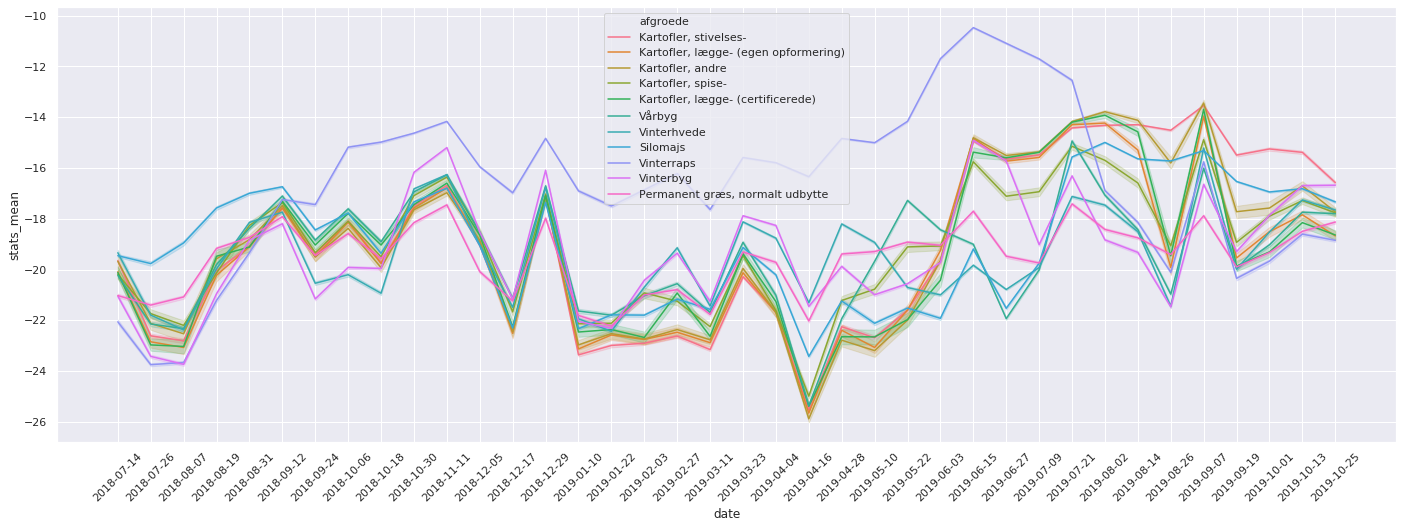

time: 41.9 s


In [107]:
df = get_plot_df(polygons_year=2019, 
                 satellite_dates=slice('2018-01-01', '2019-12-31'), 
                 fields='all',#range(100), 
                 satellite='S1A', 
                 polarization='VV')

plt.figure(figsize=(24, 8))
plt.xticks(rotation=45)
ax = sns.lineplot(x='date', y='stats_mean', hue='afgroede', data=df)

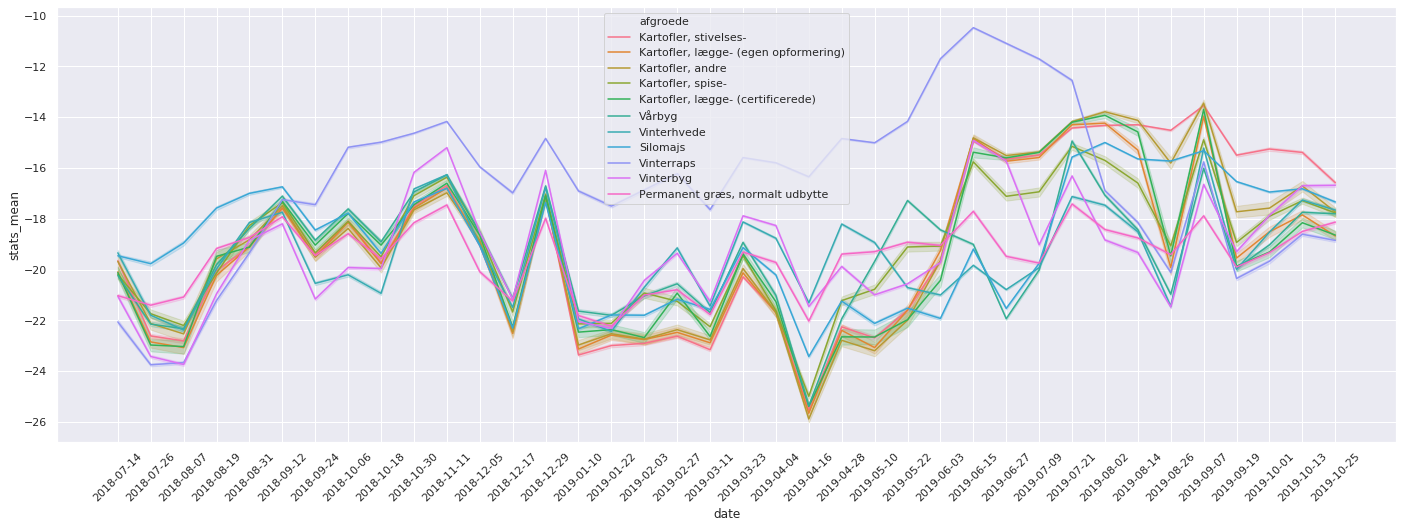

time: 41.8 s


In [136]:
df = get_plot_df(polygons_year=2019, 
                 satellite_dates=slice('2018-01-01', '2019-12-31'), 
                 fields='all',#range(100), 
                 satellite='S1A', 
                 polarization='VV-VH')

plt.figure(figsize=(24, 8))
plt.xticks(rotation=45)
ax = sns.lineplot(x='date', y='stats_mean', hue='afgroede', data=df)

Types of pass-mode: ['DSC']


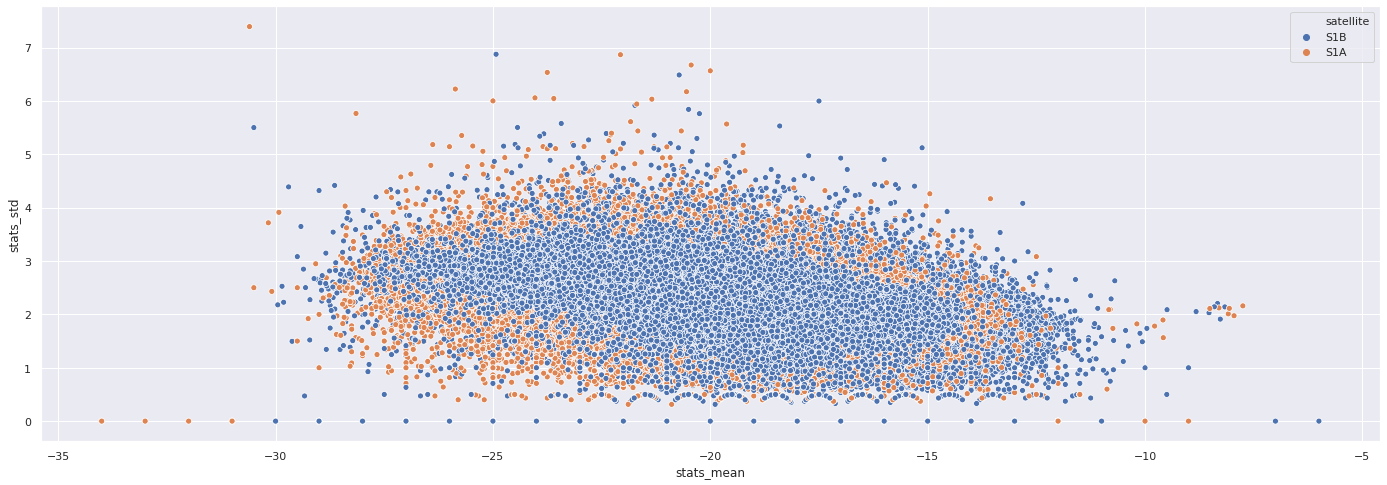

time: 18.9 s


In [12]:
df = get_plot_df(polygons_year=2019, 
                 satellite_dates=slice('2019-01-01', '2019-03-31'), 
                 fields='all', 
                 satellite='all', 
                 polarization='VV')

print("Types of pass-mode: {}".format(df['pass_mode'].unique()))

plt.figure(figsize=(24, 8))
ax = sns.scatterplot(x='stats_mean', y='stats_std', hue='satellite', data=df)

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X

<Figure size 1728x1728 with 0 Axes>

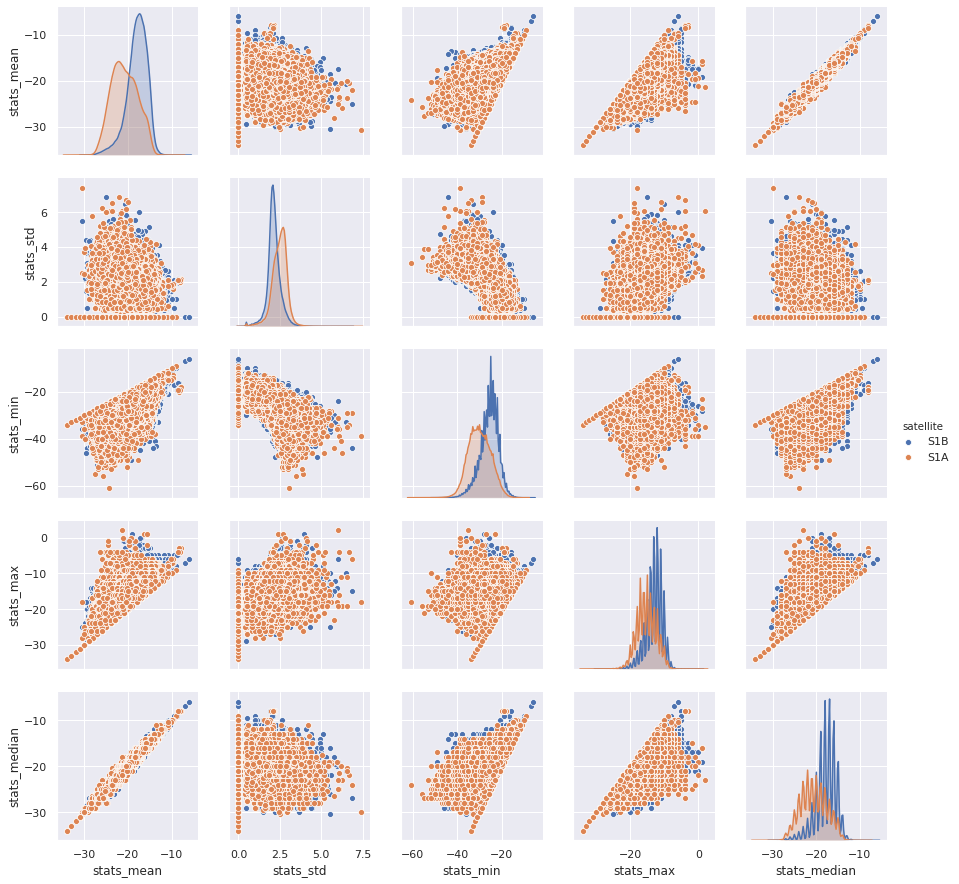

time: 1min 20s


In [13]:
df = get_plot_df(polygons_year=2019, 
                 satellite_dates=slice('2019-01-01', '2019-03-31'), 
                 fields='all', 
                 satellite='all', 
                 polarization='VV')

df = df[['satellite', 'stats_mean', 'stats_std', 'stats_min', 'stats_max', 'stats_median']]
plt.figure(figsize=(24, 24))
ax = sns.pairplot(df, hue='satellite')

Text(0.5, 1, 'Temporal evolution of: Silomajs')

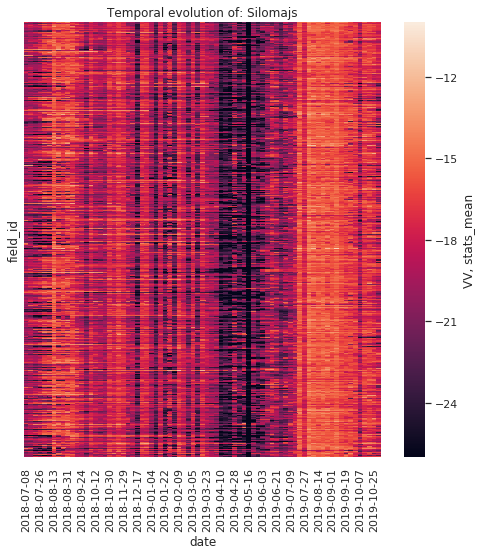

time: 5.23 s


In [137]:
afgroede = 'Silomajs'
polarization = 'VV'
num_field_ids = 1024 

df = get_plot_df(polygons_year=2019, 
                 satellite_dates=slice('2018-01-01', '2019-12-31'), 
                 fields='all', 
                 satellite='all', 
                 polarization=polarization,
                 afgroede=afgroede)

df = df.dropna()

# Pivot the df (https://stackoverflow.com/a/37790707/12045808)
df = df.pivot(index='field_id', columns='date', values='stats_mean').head(num_field_ids)

plt.figure(figsize=(8, 8))
cmap_label = "{}, stats_mean".format(polarization)
ax = sns.heatmap(df, vmin=-26, vmax=-10, yticklabels=False, cbar_kws={'label': "{}, stats_mean".format(polarization)})
title = "Temporal evolution of: {}".format(afgroede)
ax.set_title(title)

Text(0.5, 1, 'Temporal evolution of: Vinterraps')

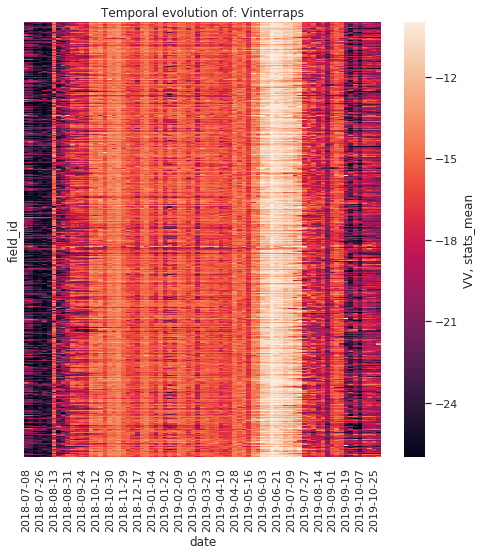

time: 5.05 s


In [138]:
afgroede = 'Vinterraps'
polarization = 'VV'
num_field_ids = 1024 

df = get_plot_df(polygons_year=2019, 
                 satellite_dates=slice('2018-01-01', '2019-12-31'), 
                 fields='all', 
                 satellite='all', 
                 polarization=polarization,
                 afgroede=afgroede)

df = df.dropna()

# Pivot the df (https://stackoverflow.com/a/37790707/12045808)
df = df.pivot(index='field_id', columns='date', values='stats_mean').head(num_field_ids)

plt.figure(figsize=(8, 8))
cmap_label = "{}, stats_mean".format(polarization)
ax = sns.heatmap(df, vmin=-26, vmax=-10, yticklabels=False, cbar_kws={'label': "{}, stats_mean".format(polarization)})
title = "Temporal evolution of: {}".format(afgroede)
ax.set_title(title)

Text(0.5, 1, 'Temporal evolution of: Kartofler, spise-')

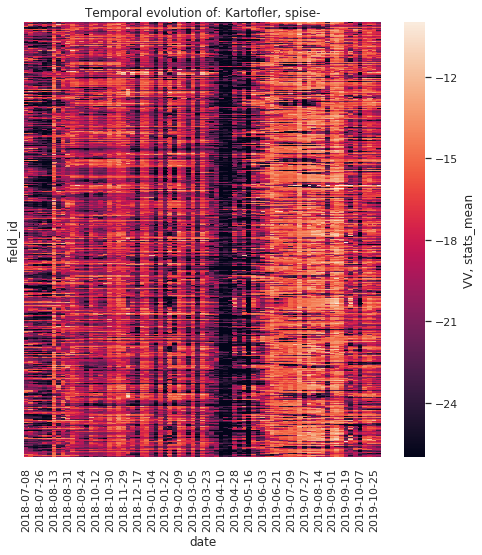

time: 3.2 s


In [139]:
afgroede = 'Kartofler, spise-'
polarization = 'VV'
num_field_ids = 1024

df = get_plot_df(polygons_year=2019, 
                 satellite_dates=slice('2018-01-01', '2019-12-31'), 
                 fields='all', 
                 satellite='all', 
                 polarization=polarization,
                 afgroede=afgroede)

df = df.dropna()

# Pivot the df (https://stackoverflow.com/a/37790707/12045808)
df = df.pivot(index='field_id', columns='date', values='stats_mean').head(num_field_ids)

plt.figure(figsize=(8, 8))
cmap_label = "{}, stats_mean".format(polarization)
ax = sns.heatmap(df, vmin=-26, vmax=-10,yticklabels=False, cbar_kws={'label': "{}, stats_mean".format(polarization)})
title = "Temporal evolution of: {}".format(afgroede)
ax.set_title(title)